# Demo 4 - Classificação de objetos com Keras

Dr. Ahirton Lopes

## 1. Requerimentos

### 1.1 Bibliotecas

Todas as bibliotecas já estão instaladas no Google Colab.

* OpenCV>=3.4.3
* Pillow>= 7.0.0
* Pytorch>=1.4.0
* Numpy>=1.18.1
* Keras >= 3.0
* Tensorflow >= 2.2.0
* Gdown >= 3.6.4

### 1.2 Arquivos

Carregando imagens previamente existentes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

## 2. Transfer learning para reconhecimento de imagens

Técnica de transfer learning aplicado a deep learnig para classificação de imagens, utilizando classificados com pesos já treinados disponibilizados no Keras.

Foram utilizadas imagens com tamanho 100 x 100 pixels, 1409 imagens por classe para o treinamento e 472 imagens por classe para validação.

### 2.1 Geradores de imagens

Os geradores utilizados foram aplicados para converter o tamanho adequado do modelo utilizado (224 x 224 pixels) como também para criar novos exemplos a partir das imagens no que chamamos de _data augmentation_, por meio de perturbações da imagem baseado em recorte (```shear```), zoom e orientação horizontal (```horizontal_flip```).

Conjunto de dados utilizado foi [este](https://www.kaggle.com/moltean/fruits), disponível no Kaggle.

*Adaptado deste [artigo](https://medium.freecodecamp.org/keras-vs-pytorch-avp-transfer-learning-c8b852c31f02), de Patryk Miziula*

Com a técnica de _data augmentation_ foram geradas 1212 imagens por classe. Ao todo, o número de imagens subiu de 794 para 2424.

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "drive/My Drive/imagens-frutas/train",
    batch_size=32,
    class_mode="binary",
    color_mode='rgb',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    "drive/My Drive/imagens-frutas/validation",
    shuffle=False,
    class_mode="binary",
    color_mode='rgb',
    target_size=(224,224))

Found 1409 images belonging to 3 classes.
Found 473 images belonging to 3 classes.


Exibindo as classes identificadas.

In [ ]:
train_generator.class_indices

{'Apple Braeburn': 0, 'Avocado': 1, 'Banana': 2}

### 2.2. Construindo a rede neural baseado em modelo pré-treinado

O Keras já possui classes especializadas para os seguintes modelos de deep-learning treinados com o conjunto de dados [ImageNet](http://www.image-net.org/):
  
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

Mais detalhes, veja na [documentação do Keras](https://keras.io/applications/).

_O Keras se encarrega de baixar o modelo automaticamente, não é preciso baixar separadamente._

Note que o parâmetro ```include_top=False``` configura o modelo para não utilizar a camada densa original, pois será substituída pelas novas classes.

In [ ]:
conv_base = VGG16(include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


Removendo a camada densa para que seja adaptada para lidar com apenas 2 classes.

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
import tensorflow as tf

optimizer = tf.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### 2.3 Treinamento do modelo

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=20,
                              validation_steps=1,
                              steps_per_epoch=1,
                              validation_data=validation_generator)

<ipython-input-8-098c281b4f92>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/20
1/1 [==============================] - 43s 43s/step - loss: 5.3241 - accuracy: 0.2500 - val_loss: 2.8134 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 8s 8s/step - loss: 1.8334 - accuracy: 0.5625 - val_loss: 0.1172 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 7s 7s/step - loss: 0.9444 - accuracy: 0.6875 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 8s 8s/step - loss: 0.2535 - accuracy: 0.9375 - val_loss: 8.8938e-05 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 9s 9s/step - loss: 0.1787 - accuracy: 0.9375 - val_loss: 1.6123e-05 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.0590 - accuracy: 1.0000 - val_loss: 7.8640e-06 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 7s 7s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.6827e-06 - val_accuracy: 1.0000
Epoch 8/20
1/1 [===

Armazenamento do modelo e carregamento do modelo pré-treinado.

In [ ]:
# salvando o modelo no formato HDf5
model.save('modelos/model-frutas.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights('modelos/weights-frutas.h5')
with open('modelos/architecture-frutas.json', 'w') as f:
    f.write(model.to_json())

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# carregando o modelo no formato HDf5
model = load_model('modelos/model-frutas.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
with open('modelos/architecture-frutas.json') as f:
    model = model_from_json(f.read())

model.load_weights('modelos/weights-frutas.h5')

### 2.4 Predição nas imagens de teste

In [ ]:
import cv2

validation_img_paths = ["drive/My Drive/imagens-frutas/validation/Apple Braeburn/7_100.jpg",
                        "drive/My Drive/imagens-frutas/validation/Avocado/49_100.jpg",
                        "drive/My Drive/imagens-frutas/validation/Banana/12_100.jpg"]

img_list = [Image.open(img_path) for img_path in validation_img_paths]

Normalizando as imagens de teste, utilizando np.stack

In [ ]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [ ]:
pred_probs = model.predict(validation_batch)

1/1 [==============================] - 2s 2s/step


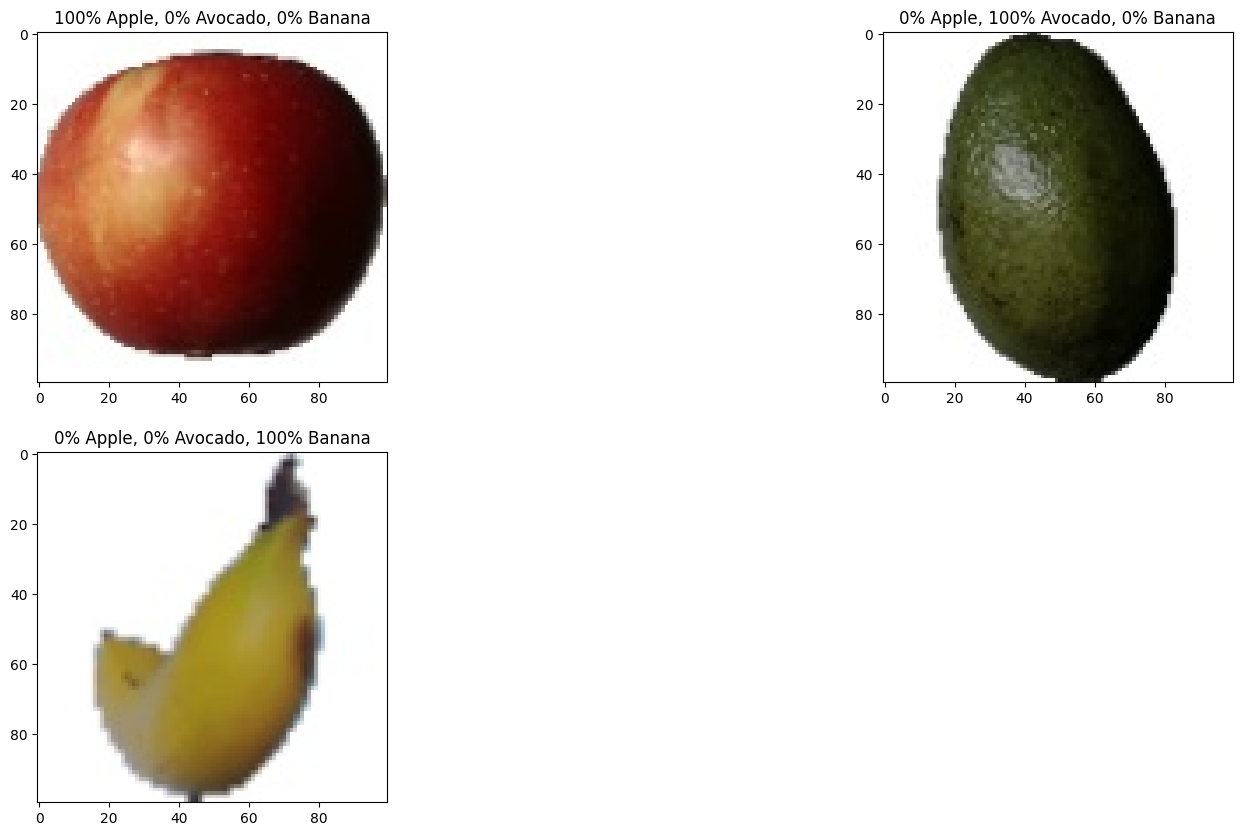

In [ ]:
plt.figure(figsize=(20,10))

for i, imagem in enumerate(img_list):
    plt.subplot(2,2,i+1)
    plt.imshow(imagem)
    plt.title("{:.0f}% Apple, {:.0f}% Avocado, {:.0f}% Banana".format(100*pred_probs[i,0], 100*pred_probs[i,1], 100*pred_probs[i,2]))